# Assignment 1: Time Series Forecast With Python (Seasonal ARIMA)

**Lecturer**: Vincent Claes<br>
**Authors:** Bryan Honof, Jeffrey Gorissen<br>
**Start Date:** 19/10/2018
    
**Objective:** Visualize and predict the future temperatures via ARIMA

**Description:** This notebook takes care of downloading the data from either the weblink or the heroku database. Fixes all the errors in the data and outputs it to a ```.csv``` file

## Table of contents

1. [Import Libraries](#Import-Libraries)
2. [Get Data](#Get-Data)  
3. [Wrangle the Data](#Wrangle-the-Data)<br>
    a. [restructure the dataframe](#restructure-the-dataframe)<br>
    b. [create a timeseries dataframe](#create-a-timeseries-dataframe)
4. [Fixing the errors in the data](#fixing)

## 1. Import Libraries <a name="Import-Libraries"></a>

To start, we will import some package: in this case, we will make use of:
* ```subprocess``` to run commands on our machine
* ```pandas```     to create dataframes and retreive data
* ```matplotlib``` to plot our data
* ```sqlalchemy``` to create an engine to connect to the database

In [15]:
import subprocess

import pandas            as pd
import ipywidgets        as widgets
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

## 2. Get Data <a name="Get-Data"></a>

We have 2 options here toggled by the 'in_school' variable.
If this variable is set to True we will obtain our data by pulling a JSON object from the heroku webserver.
If it is set to False we will obtain it by first connecting to the Heroku PostgreSQL database and applying a simple SQL querry to that database.

In [38]:
def func(database):
    bryan_domain   = 'pxl-ss'
    jeffrey_domain = 'ss-pxl-11603121'
    
    print('database is set to:')
    
    if (database):
        return jeffrey_domain
    else:
        return bryan_domain
    
    return database

dropdown = widgets.interactive(func, database=[('Bryan\'s database', 0),('Jeffrey\'s database', 1)]);

display(dropdown)

interactive(children=(Dropdown(description='database', options=(("Bryan's database", 0), ("Jeffrey's database"…

In [41]:
name_dbApp = dropdown.result
print(name_dbApp)
in_school = True

if (True == in_school):
    # Get the data from the web route because school blocks the port used by the database :)
    
    url  = 'https://' + name_dbApp + '.herokuapp.com/api/temps'
    data = pd.read_json(url, orient='columns')
else:
    # Get the data directly from the database
    
    HEROKU_APP_NAME = name_dbApp
    TABLE_NAME      = "Temperature"

    conn_info = subprocess.run(["heroku", "config:get", "DATABASE_URL", "-a", HEROKU_APP_NAME], stdout = subprocess.PIPE)
    connuri   = conn_info.stdout.decode('utf-8').strip()

    engine     = create_engine(connuri)
    raw_engine = engine.raw_connection()

    data = pd.read_sql_query("SELECT * FROM Temperature;", raw_engine)

ss-pxl-11603121


In [42]:
# Make sure we recieved the data correctly by printing out the head()
data.tail(5)

,creation_date,id,place,value
7,2018-11-19T14:53:09.024887+00:00,8,Jeffrey Kot,25.36
8,2018-11-19T15:08:11.393082+00:00,9,Jeffrey Kot,24.65
9,2018-11-19T15:23:13.164845+00:00,10,Jeffrey Kot,29.39
10,2018-11-19T15:38:15.217371+00:00,11,Jeffrey Kot,26.81
11,2018-11-19T15:53:17.522012+00:00,12,Jeffrey Kot,27.37


## 3. Wrangle the Data <a name="Wrangle-the-Data"></a>

The first thing we want to do is get rid of the columns we are not interested in.

In this case we are only interested in the ```creation_date``` column and the ```value``` column. We will also rename these to column to ```dateTime``` and ```temperature``` just for ease of use.

### a. restructure the dataframe <a name="restructure-the-dataframe">

In [19]:
# Filter out all the columsn except for 'creation_date' & 'value'
# Rename those columns to 'dateTime' & temperature
df = pd.DataFrame(data, columns = ['creation_date', 'value'])
df.columns = ['dateTime', 'temperature']

# Double check the results of the reassignment
df.head(5)

,dateTime,temperature
0,2018-11-10T23:38:44.453789+00:00,21.48
1,2018-11-10T23:53:53.134313+00:00,19.48
2,2018-11-10T23:53:57.457321+00:00,20.60
3,2018-11-10T23:56:10.690055+00:00,20.45
4,2018-11-10T23:58:49.577553+00:00,20.76


### b. create a timeseries dataframe <a name="create-a-timeseries-dataframe">
    
Since we want a time series dataframe we still have to set the ```dateTime``` column to be our index. But to do this it still has to be converted to type type of ```Datetime``` first.

In [20]:
# Convert the creation_date column to datetime64
df['dateTime'] = pd.to_datetime(df.dateTime)
# Convert the value column to float
df['temperature'] = pd.to_numeric(df.temperature)

# Set the dateTime column as index
df.set_index(['dateTime'], inplace=True)

# Double check the results
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 798 entries, 2018-11-10 23:38:44.453789 to 2018-11-19 16:02:28.845848
Data columns (total 1 columns):
temperature    798 non-null float64
dtypes: float64(1)
memory usage: 12.5 KB


## 4. Fixing the errors in the data <a name="fixing"></a>

Like we saw in the previous step something went wrong when we were collecting our data.<br>
To fix this we are going to do 2 things.
* downsample our data to have a frequency of 15mins
* get rid of all NaN values

In [21]:
# Change the frequency to 15mins
df_resample = df.resample('15T').mean()

In [22]:
df_resample.head()

,temperature
dateTime,
2018-11-10 23:30:00,21.480000
2018-11-10 23:45:00,20.322500
2018-11-11 00:00:00,20.906316
2018-11-11 00:15:00,21.330000
2018-11-11 00:30:00,22.177500


In [23]:
df_resample.isnull().sum()

temperature    76
dtype: int64

This output tells us that there are (at the moment of writing this) 75 NaN values in our dataframe

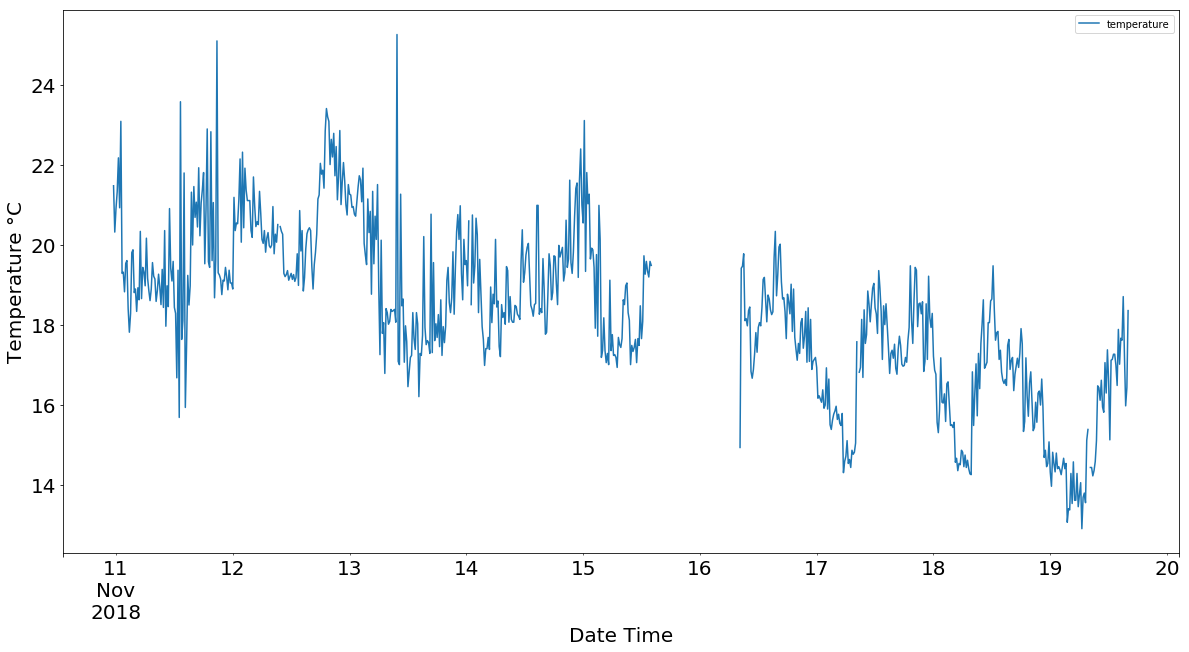

In [24]:
df_resample.plot(figsize=(20, 10), fontsize=20)
plt.xlabel('Date Time', fontsize=20)
plt.ylabel('Temperature °C', fontsize=20)
plt.show()

By plotting out the dataframe we can clearly see the missing data.

In [25]:
df_resample = df_resample.interpolate(method='linear')
df_resample = df_resample.round(2)

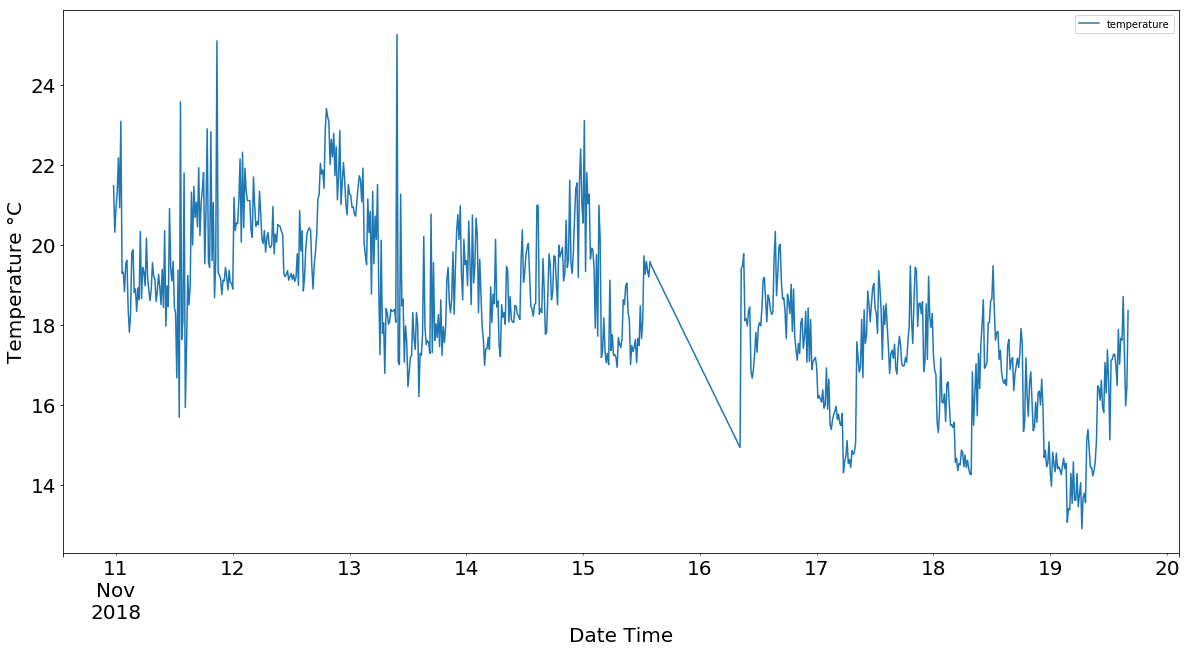

In [26]:
df_resample.plot(figsize=(20, 10), fontsize=20)
plt.xlabel('Date Time', fontsize=20)
plt.ylabel('Temperature °C', fontsize=20)
plt.show()

But guys... this chart looks exactly the same like the one you first said was wrong! Do you even know what you are doing???

Well yes they look identical but the difference between the 2 is that this one accually has values for each index. The previous chart skipped some indexes.

In [27]:
df = df_resample

In [28]:
df.to_csv('data.csv')